In [21]:
import sys
sys.path.append("models")
import torch
import numpy as np

# GIN
from torch.nn import Linear, ReLU, Softmax
from torch_geometric.nn import Sequential, GINConv
from torchvision.ops import MLP

# Dataset & model wrapper
import pandas as pd
import networkx as nx
import numpy as np
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
from torch.utils.data import random_split
from torch_geometric.data import Data
import time
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# SAGE
from torch.nn import Dropout
from torch_geometric.nn import SAGEConv

2.6.0


In [22]:
class GNN_GIN_Model(torch.nn.Module):

    def __init__(self, hidden_size: int,
                 input_size: int, 
                 output_size: int,
                 num_layers: int):
        super().__init__()
        torch.manual_seed(12345)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.output_size = output_size
        #self.mlp = Linear(in_size, output_size)
        #self.sm = Softmax(dim=0)

        self.convs = torch.nn.ModuleList()
        for l in range(num_layers):
            #in_size = dataset_num_features if l == 0 else hidden_size
            in_size = input_size if l == 0 else hidden_size
            in_size2 = hidden_size + input_size if l == 0 else hidden_size*2
            
            # My code with fixes
            # Define an MLP for GINConv
            mlp = torch.nn.Sequential(
                Linear(in_size, hidden_size),
                ReLU(),
                Linear(hidden_size, hidden_size)
            )
            # GINConv takes only the MLP, not in_channels/out_channels
            conv = GINConv(mlp)


            # -> Original code but error
            # conv = GINConv(in_channels=in_size, out_channels=hidden_size,nn= Linear(in_size, hidden_size))
            #conv = GINConv(in_channels=in_size, out_channels=hidden_size,nn= MLP(in_size, [hidden_size,hidden_size]))
            
            #mpnn = MPNN(in_channels=in_size, out_channels=hidden_size, in_channels2=in_size2)
            self.convs.append(conv)

        self.lin_out = Linear(hidden_size, output_size)
    
    def forward(self, x, edge_index, edge_weight=None):
       
        # Message-passing: transform node features based on neighbors
        m = ReLU(inplace=True)
        #print(x.dtype)
        for conv in self.convs:
            x = conv(x, edge_index, edge_weight)
            x = torch.tanh(x)
            #print(x.dtype)
            #x = conv(x, edge_index, edge_attr=edge_attr)
        # Decoder: post-process extracted features
        
        out = self.lin_out(x)
        #out = self.sm(out) #does not work with softmax...?
        return out



In [23]:
class Dataset:
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("device:",self.device)
        self.data = None


    def load_dataset(self,folder,splits=[.35,.15,.50],split_type="normal",split_seed=0):  
        self.folder = folder
        accounts_df = pd.read_csv(folder+"/account_attributes.csv")
        transactions_df = pd.read_csv(folder+"/transactions.csv")

        nodes_df = accounts_df
        edges_df = transactions_df

        fp =np.round(nodes_df[nodes_df.node_isSar == 1.0].shape[0] / nodes_df.shape[0],4)*100

        print("loading dataset",folder,"|","length:",nodes_df.shape[0],"| fraud percentage (%):",fp)

        x_np = nodes_df.to_numpy()
        X = x_np[:,0:-2] # Exclude last two columns: id and target (target will be used later with y)
        
        self.feature_labels = nodes_df.columns.tolist()
        
        # Define your graph
        # create a matrix where each row correspond to an account and each column is an attribute
        X = torch.tensor(X)  # (n x features)
        
        # Edge index is a tensor representing graph's connections (from orig to bene)
        edge_index =  torch.stack([torch.tensor(edges_df.orig_acct.to_numpy()),
                                   torch.tensor(edges_df.bene_acct.to_numpy())],dim=-1).T  # Define your edge index
        
        # the weight of every edge is the amount of the transaction
        edge_weight = torch.nn.functional.normalize(torch.tensor(edges_df.base_amt.to_numpy()),dim=0).long()
        
        # The target is given by the column 'node_isSar' of account_attributes.csv
        y =  torch.tensor(nodes_df.node_isSar.to_numpy().astype(int),dtype=torch.long) # target values
                                                                                       # If node_isSar == 1, the account is flagged as fraudulent.
                                                                                       # If node_isSar == 0, the account is normal.

        #normalization methods
        # method 1
        X = torch.nn.functional.normalize(X,dim=0).to(torch.float32)
        #dim 0 is vertical (features)
        #dim 1 is horizontal (nodes)

        train_size = int(splits[0] * len(y))  # 60% of the dataset for training
        val_size = int(splits[1] * len(y))    # 20% of the dataset for validation
        test_size = len(y) - train_size - val_size  # Remaining 20% for testing

        torch.manual_seed(split_seed)
        train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

        new_trainset_indices = []
        if split_type == "imbalanced_method":
            a = np.array(train_dataset.indices)
            b = y[a]
            pos_samples_in_trainset = a[b==1]
            c = a[b==0]
            scalar = 5 # ensure that fraud cases appear more frequently in training
            neg_samples_in_trainset = np.random.choice(len(c), len(pos_samples_in_trainset)*scalar, replace=False)
            new_trainset_indices = np.concatenate((pos_samples_in_trainset, neg_samples_in_trainset))
            train_dataset.indices = new_trainset_indices
        else:
            pass

        # Create masks for train, validation, and test sets
        self.train_mask = torch.zeros(len(y), dtype=torch.bool)
        self.val_mask = torch.zeros(len(y), dtype=torch.bool)
        self.test_mask = torch.zeros(len(y), dtype=torch.bool)

        self.train_mask[train_dataset.indices] = True
        self.val_mask[val_dataset.indices] = True
        self.test_mask[test_dataset.indices] = True
        
        # Create the graph with PyTorch Geometric
        self.data = Data(X=X, # account
                         edge_index=edge_index, # transaction
                         edge_weight=edge_weight, # amount transfered
                         y=y, # fraudolent or not
                         train_mask=self.train_mask, val_mask=self.val_mask, test_mask=self.test_mask)
        self.data.to(self.device)

In [24]:
class ModelGIN:
    def __init__(self, data,save_model=False,save_model_path="default.pth", gridsearch_flag=False):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("device:",self.device)
        self.data = data
        self.optimizer = None
        self.criterion = None
        self.model = None
        self.lr = 0.005
        self.beta = 0.23
        self.w2 = [1,len(data.y==0)/len(data.y==1)]
        self.save_model = save_model
        self.save_model_path = save_model_path
        self.gridsearch_flag = gridsearch_flag
        self.gridsearch_results = {
            'test_f1':0,
            'test_auc':0,
            'test_precision':0,
            'test_recall':0,
            'test_epoch':0
        }

        if self.gridsearch_flag == False:
            self.writer = SummaryWriter()


    def load_model(self, K=1, F=8, additional_params={}):
        self.dataset_num_features = self.data.X.size()[1]
        self.dataset_num_classes = 2
        self.K = K
        self.F = F
        self.additional_params = additional_params
        
        self.model = GNN_GIN_Model(hidden_size=self.F, input_size=self.dataset_num_features, output_size=self.dataset_num_classes, num_layers=self.K)
            
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, amsgrad=True)
        self.criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([self.beta,1.0]).to(self.device))
        self.model.to(self.device)


    def train_model(self,epochs):
        print("model training starting...")
        st = time.time()
        best_f1_val_score = 0
        for epoch in range(0, epochs):
            self.model.train()
            self.optimizer.zero_grad()
            # We now give as input also the graph connectivity
            out = self.model(self.data.X, self.data.edge_index)
            
            loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        

            if epoch%10 == 0 and self.gridsearch_flag == False:
                train_acc, train_out, train_pred = self.test(self.data.train_mask,self.data)
                precision, recall, f1_score, _ = precision_recall_fscore_support(self.data.y[self.data.train_mask].cpu(), train_pred.cpu(), average='binary')
                self.writer.add_scalar('Loss/train', loss.item(), epoch)
                self.writer.add_scalar('Accuracy/train',train_acc, epoch)
                self.writer.add_scalar('F1/train',f1_score, epoch)
                self.writer.add_scalar('Precision/train',precision, epoch)
                self.writer.add_scalar('Recall/train',recall, epoch)

            #loss = sigmoid_focal_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            self.optimizer.step()

            if epoch%10 == 0:
                # validation

                val_acc, val_out, val_pred = self.test(self.data.val_mask,self.data)
                val_loss = self.criterion(out[self.data.val_mask], self.data.y[self.data.val_mask])
                precision, recall, f1_score, _ = precision_recall_fscore_support(self.data.y[self.data.val_mask].cpu(), val_pred.cpu(), average='binary')
                
                if self.gridsearch_flag == False:
                    self.writer.add_scalar('Accuracy/validation',val_acc, epoch)
                    self.writer.add_scalar('Loss/validation',val_loss, epoch)
                    self.writer.add_scalar('F1/validation',f1_score, epoch)
                    self.writer.add_scalar('Precision/validation',precision, epoch)
                    self.writer.add_scalar('Recall/validation',recall, epoch)
            
                if f1_score > best_f1_val_score:
                    best_f1_val_score = f1_score
                    if self.save_model == True:
                        torch.save(self.model.state_dict(), self.save_model_path)
                    if self.gridsearch_flag == True: #THIS IS USUALLY USED IN COMBINATION WITH THE GRIDSEARCH FILE. this is only a component of the gridsearch
                        test_acc, test_out, test_pred = self.test(self.data.test_mask,self.data)
                        precision, recall, f1_score, _ = precision_recall_fscore_support(self.data.y[self.data.test_mask].cpu(), test_pred.cpu(), average='binary')
                        y_true = self.data.y[self.data.test_mask].cpu()
                        y_pred = test_pred.detach().cpu().numpy()
                        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
                        roc_auc = auc(fpr, tpr)
                        self.gridsearch_results['test_f1'] = f1_score
                        self.gridsearch_results['test_precision'] = precision
                        self.gridsearch_results['test_recall'] = recall
                        self.gridsearch_results['test_auc'] = roc_auc
                        self.gridsearch_results['test_epoch'] = epoch
                        self.run_results = self.gridsearch_results #simply show the run results outside of the full gridsearch setting
                '''
                if f1_score > self.best_f1_from_gs:
                    tpfp = self.check_topology_performance('v2/128K_05_v2_2', self.data)
                    results = {
                    'tp':tpfp[0],
                    'fp':tpfp[1],
                    }
                    print('########################################')
                    print('########################################')
                    print('########################################')
                    print('########################################')
                    print(results)
                    print(f1_score)
                    print('########################################')
                    print('########################################')
                    print('########################################')
                    print('########################################')
                '''        

        et = time.time()
        elapsed_time = np.round(et - st,2)
        print("model training done. elapsed time:", elapsed_time, "seconds")
        

    def test(self,mask,data):
        self.model.eval()
        out = self.model(data.X, data.edge_index)
        #out = model(data.X, data.edge_index,data.edge_weight)
        pred = out.argmax(dim=1)
        test_correct = pred[mask] == data.y[mask]
        test_acc = int(test_correct.sum()) / int(mask.sum())
        test_out = out[mask]
        test_pred = pred[mask]
        return test_acc, test_out, test_pred

    def test_model(self,data):
        test_acc, test_out, test_pred = self.test(data.test_mask,data)
        precision, recall, f1_score, _ = precision_recall_fscore_support(data.y[data.test_mask].cpu(), test_pred.cpu(), average='binary')

        print('test acc:',np.round(test_acc*100,2))
        print('test precision:',np.round(precision*100,2))
        print('test recall:',np.round(recall*100,2))
        print('test f1-score:',np.round(f1_score*100,2))

    def check_topology_performance(self, folder, data):
        ### Here we colour nodes

        # col 1
        # 1 -> in training/val set
        # 2 -> true positive
        # 3 -> true negative
        # 4 -> false positive
        # 5 -> false negative
        test_acc, test_out, test_pred = self.test(data.test_mask,data)
        test_pred = test_pred.detach().cpu()
        y_true = data.y[data.test_mask].cpu()
        precision, recall, f1_score, _ = precision_recall_fscore_support(data.y[data.test_mask].cpu(), test_pred.cpu(), average='binary')
        
        accounts_df = pd.read_csv(folder+"/account_attributes.csv")

        indicies = accounts_df.index

        out = np.array(test_pred)  # Convert 'out' to a NumPy array for easier indexing
        true_labels = np.array(y_true)  # Convert 'true_labels' to a NumPy array for easier indexing

        # True Positives (TP)
        tp_indices = np.where((out == 1) & (true_labels == 1))[0]
        #print("true positives =",len(tp_indices))
        tp_indices = indicies[data.test_mask.cpu().numpy()][tp_indices]

        # True Negatives (TN)
        tn_indices = np.where((out == 0) & (true_labels == 0))[0]
        #print("true negatives =",len(tn_indices))
        tn_indices = indicies[data.test_mask.cpu().numpy()][tn_indices]

        # False Positives (FP)
        fp_indices = np.where((out == 1) & (true_labels == 0))[0]
        #print("false positives =",len(fp_indices))
        fp_indices = indicies[data.test_mask.cpu().numpy()][fp_indices]

        # False Negatives (FN)
        fn_indices = np.where((out == 0) & (true_labels == 1))[0]
        #print("false negatives =",len(fn_indices))
        fn_indices = indicies[data.test_mask.cpu().numpy()][fn_indices]

        '''
        accounts_df['trained_color'] = "#000000"
        accounts_df['trained_color'][train_mask.numpy()] = "#343B46"
        accounts_df['trained_color'][val_mask.numpy()] = "#343B46"
        accounts_df['trained_color'][tp_indices] = "#eb4034"
        accounts_df['trained_color'][tn_indices] = "#1ad623"
        accounts_df['trained_color'][fp_indices] = "#26e0be"
        accounts_df['trained_color'][fn_indices] = "#fae01e"
        '''

        accounts_df['trained_color'] = 1
        accounts_df['trained_color'][data.train_mask.cpu().numpy()] = 2
        accounts_df['trained_color'][data.val_mask.cpu().numpy()] = 2
        accounts_df['trained_color'][tp_indices] = 3
        accounts_df['trained_color'][tn_indices] = 4
        accounts_df['trained_color'][fp_indices] = 5
        accounts_df['trained_color'][fn_indices] = 6

        #accounts_df['id'] = indicies
        accounts_df['id'] = (accounts_df['id']).astype(int)

        #accounts_df.to_csv('../datasets/60K_01_sar_count/account_attributes_trained_vis_SAGE.csv',index=0)

        #np.sum(accounts_df['trained_color'] == 0), len(train_dataset), len(val_dataset), len(test_dataset)

        sar_df = pd.read_csv(folder+"/alert_accounts.csv")

        ids_cycle = sar_df["acct_id"][sar_df["alert_type"]=='cycle'].to_numpy() #super important to convert to numpy array!!!!! keeping as pandas series messes up all indexing!!!
        ids_fan_in = sar_df["acct_id"][sar_df["alert_type"]=='fan_in'].to_numpy()
        ids_fan_out = sar_df["acct_id"][sar_df["alert_type"]=='fan_out'].to_numpy()
        ids_gather_scatter = sar_df["acct_id"][sar_df["alert_type"]=='gather_scatter'].to_numpy()
        ids_scatter_gather = sar_df["acct_id"][sar_df["alert_type"]=='scatter_gather'].to_numpy()
        ids_bipartite = sar_df["acct_id"][sar_df["alert_type"]=='bipartite'].to_numpy()
        ids_stack = sar_df["acct_id"][sar_df["alert_type"]=='stack'].to_numpy()
        set(sar_df["alert_type"])

        #print('ids_cycle',ids_cycle)

        ids_test_set = accounts_df['id'][data.test_mask.cpu().numpy()].astype(int).to_numpy()
        labels_test_set = data.y[data.test_mask].cpu().numpy()
        predictions_test_set = test_pred.numpy()
        correct_pos_pred = np.logical_and(labels_test_set, predictions_test_set) # is can only equal 1 if both label and precition were 1

        pred_cycle = correct_pos_pred[[e in ids_cycle for e in ids_test_set]]
        pred_fan_in = correct_pos_pred[[e in ids_fan_in for e in ids_test_set]]
        pred_fan_out = correct_pos_pred[[e in ids_fan_out for e in ids_test_set]]
        pred_gather_scatter = correct_pos_pred[[e in ids_gather_scatter for e in ids_test_set]]
        pred_scatter_gather = correct_pos_pred[[e in ids_scatter_gather for e in ids_test_set]]
        pred_bipartite = correct_pos_pred[[e in ids_bipartite for e in ids_test_set]]
        pred_stack = correct_pos_pred[[e in ids_stack for e in ids_test_set]]

        topologies = ('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack')

        tp = np.round(np.array([np.sum(pred_cycle)/len(pred_cycle), np.sum(pred_fan_in)/len(pred_fan_in), np.sum(pred_fan_out)/len(pred_fan_out), np.sum(pred_gather_scatter)/len(pred_gather_scatter), np.sum(pred_scatter_gather)/len(pred_scatter_gather), np.sum(pred_bipartite)/len(pred_bipartite), np.sum(pred_stack)/len(pred_stack)]),2)
        fp = np.ones(len(tp)) - tp
        topology_counts = {
            'True Positive': tp,
            'False Positive': fp,
        }
        width = 0.6  # the width of the bars: can also be len(X) sequence
        #print(1)
            
        fig, ax = plt.subplots()
        #print(2)
        bottom = np.zeros(7)
        #print(3)
        for top, top_count in topology_counts.items():
            print(topologies, top_count)
            p = ax.bar(topologies, top_count, width, label=top, bottom=bottom)
            bottom += top_count

            ax.bar_label(p, label_type='center')
        #print(4)
        ax.set_title('Model Performance by Topology Type')
        #print(5)
        ax.legend()
        #print(6)

        plt.show()
        #plt.savefig('topologies_perf.png')
        
        return [tp,fp]

In [25]:
#We load the datasets that we will use to train, validate, and test the models. 
#We split the datasets accordingly with 50% of nodes in training set, 20% in validation set, and 30% in testing set.

ds1 = Dataset()
ds1.load_dataset(folder='datasets/64K_5',splits=[.5,.2,.3],split_seed=111)

# ds2 = mh.Dataset()
# ds2.load_dataset(folder='datasets/32K_5',splits=[.5,.2,.3],split_seed=222)

device: cpu
loading dataset datasets/64K_5 | length: 64026 | fraud percentage (%): 4.91


In [26]:
ds1.data

Data(edge_index=[2, 1510182], y=[64026], X=[64026, 27], edge_weight=[1510182], train_mask=[64026], val_mask=[64026], test_mask=[64026])

In [27]:
fraud_count = ds1.data.y.sum().item()
total_count = len(ds1.data.y)
print(f"Fraud Cases: {fraud_count}, Non-Fraud Cases: {total_count - fraud_count}")

Fraud Cases: 3142, Non-Fraud Cases: 60884


In [28]:
num_nodes = ds1.data.X.shape[0]
num_edges = ds1.data.edge_index.shape[1]
print(f"Nodes: {num_nodes}, Edges: {num_edges}")

Nodes: 64026, Edges: 1510182


In [29]:
#we can view our feature matrix X
print(ds1.data.X)
#and our target vector y
print(ds1.data.y)

tensor([[4.1853e-03, 0.0000e+00, 0.0000e+00,  ..., 5.3289e-04, 2.4331e-03,
         2.4103e-03],
        [4.7069e-03, 0.0000e+00, 0.0000e+00,  ..., 7.9614e-04, 1.5770e-03,
         1.5782e-03],
        [2.9600e-03, 0.0000e+00, 0.0000e+00,  ..., 1.9672e-08, 2.2058e-03,
         2.1757e-03],
        ...,
        [4.7069e-03, 4.9121e-03, 4.9109e-03,  ..., 2.5755e-03, 0.0000e+00,
         0.0000e+00],
        [4.7069e-03, 4.9121e-03, 4.9109e-03,  ..., 1.9475e-03, 0.0000e+00,
         0.0000e+00],
        [4.7069e-03, 4.9121e-03, 4.9109e-03,  ..., 2.6889e-03, 0.0000e+00,
         0.0000e+00]])
tensor([0, 0, 0,  ..., 0, 0, 0])


- The model learns how transactions flow between accounts.
- Fraudulent accounts often have different transaction patterns compared to normal accounts.
- GNNs can propagate information across the graph, detecting fraud based on both node features and relationships.

How a GNN Classifies Fraud?
- Each account gets a feature embedding from its attributes.
- Message passing happens between connected nodes (transactions).
- The model learns patterns of fraudulent transactions.

GIN is designed to capture graph structure more effectively than standard GCNs (Graph Convolutional Networks). It is particularly powerful for:

- Learning node representations with high expressiveness.
- Capturing structural information better than GCN.
- Handling complex relationships, which is useful in fraud detection.

Why might GIN not be enough?
- GIN focuses heavily on local node neighborhoods, but it might not generalize well to large graphs.
- It doesn’t account for different types of node influences (some neighbors may be more important than others).
- Can suffer from oversmoothing if too many layers are used.

In [30]:
#Lets first load in the GIN model
model = ModelGIN(ds1.data,gridsearch_flag=True) #init model
model.beta = .44 #set binary cross entropy weight of majority class
model.lr = 0.005 #set the learning rate
model.load_model(K=2,F=8) #load the model type with specified number of layers K and hidden-dimension F
model.train_model(epochs=1000) #train the model! (for better performance, 5000 epochs is sufficient)

device: cpu
model training starting...


/opt/anaconda3/envs/GAMLNet/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/GAMLNet/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/GAMLNet/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/GAMLN

model training done. elapsed time: 120.59 seconds


In [31]:
#lets view some results

#here we find the results of the best trained model for all epochs
print("Results of model after all epochs")
print(model.run_results)
print()

print("Results on test dataset after training")
print(model.test_model(ds1.data)) #this is simply the model at the last epoch of training.. maybe not the best performing epoch



Results of model after all epochs
{'test_f1': 0.535889070146819, 'test_auc': np.float64(0.823666017913318), 'test_precision': 0.43654485049833885, 'test_recall': 0.6937697993664202, 'test_epoch': 990}

Results on test dataset after training
test acc: 94.12
test precision: 43.97
test recall: 70.01
test f1-score: 54.01
None


/var/folders/s6/4jprwbqj4012tkll2ww6r5hr0000gq/T/ipykernel_25510/1795358966.py:194: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  accounts_df['trained_color'][data.train_mask.cpu().numpy()] = 2
/var/folders/s6/4jprwbqj4012tkll2ww6r5hr0000gq/

('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack') [0.86 0.68 0.75 0.82 0.85 0.58 0.35]
('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack') [0.14 0.32 0.25 0.18 0.15 0.42 0.65]


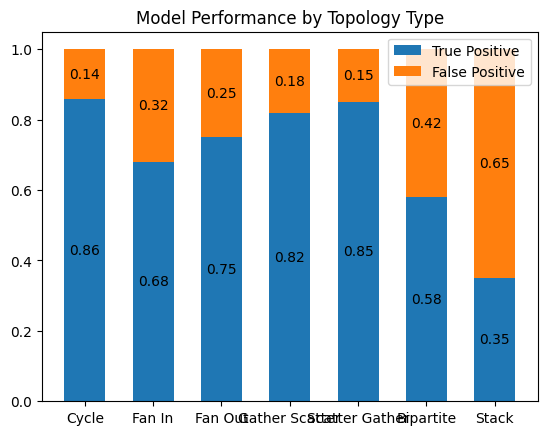

[array([0.86, 0.68, 0.75, 0.82, 0.85, 0.58, 0.35]),
 array([0.14, 0.32, 0.25, 0.18, 0.15, 0.42, 0.65])]

In [32]:
model.check_topology_performance(folder=ds1.folder, data=ds1.data)

In [33]:
class GNN_SAGE_Model(torch.nn.Module):

    def __init__(self, hidden_size: int,
                 input_size: int, 
                 output_size: int,
                 num_layers: int):
        super().__init__()
        torch.manual_seed(12345)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.output_size = output_size

        self.convs = torch.nn.ModuleList()
        for l in range(num_layers):
            #in_size = dataset_num_features if l == 0 else hidden_size
            in_size = input_size if l == 0 else hidden_size
            in_size2 = hidden_size + output_size if l == 0 else hidden_size*2
            conv = SAGEConv(in_channels=in_size, out_channels=hidden_size)
            
            #mpnn = MPNN(in_channels=in_size, out_channels=hidden_size, in_channels2=in_size2)
            self.convs.append(conv)

        self.lin_out = Linear(hidden_size, output_size)
    
    def forward(self, x, edge_index):
        # Message-passing: transform node features based on neighbors
        relu = ReLU(inplace=True)
        dropout = Dropout(p=0.2,inplace=True)
        #print(edge_index.dtype)
        for conv in self.convs:
            x = conv(x, edge_index)
            #x = dropout(x)
            x = relu(x)
            #x = conv(x, edge_index, edge_attr=edge_attr)
        # Decoder: post-process extracted features
        x = x.to(torch.float32)
        out = self.lin_out(x)
        return out

In [34]:
# GIN + SAGE
class GNN_GAMLNET_Model(torch.nn.Module):

    def __init__(self, hidden_size1: int,
                 hidden_size2: int,
                 input_size1: int, 
                 input_size2: int,
                 output_size: int,
                 num_layers1: int,
                 num_layers2: int,
                 gin_feature_indices):
        super().__init__()
        torch.manual_seed(12345)
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.num_layers1 = num_layers1
        self.num_layers2 = num_layers2
        self.input_size1 = input_size1
        self.input_size2 = input_size2 + hidden_size1 #here we do this because we concat output of gin and input of sage
        self.output_size = output_size
        self.gin_feature_indices = gin_feature_indices
        #self.mlp = Linear(in_size, output_size)
        #self.sm = Softmax(dim=0)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


        #NOTE: MAYBE I NEED TO REMOVE LINEAR LAYER AT THE END OF GIN
        self.gin_model =  GNN_GIN_Model(hidden_size=self.hidden_size1, input_size=self.input_size1, output_size=self.hidden_size1, num_layers=self.num_layers1)
        self.sage_model = GNN_SAGE_Model(hidden_size=self.hidden_size2, input_size=self.input_size2, output_size=self.output_size, num_layers=self.num_layers2)



    def forward(self, x, edge_index, edge_weight=None):
        # Message-passing: transform node features based on neighbors
        x1 = x
        if self.gin_feature_indices[0] == -1:
            x1 = torch.ones(x.size()[0], 1).to(self.device) #ONLY USE THIS IF NO FEATURES ARE WANTED
        elif self.gin_feature_indices == None:
            x1 = x
        else:
            # here we modify x to only include structural information
            x1 = x[:,self.gin_feature_indices]
        x1 = self.gin_model(x1, edge_index)

        #x1 = torch.nn.functional.normalize(x1,dim=0).to(torch.float32)
        x = torch.cat((x, x1), dim=1)
        
        out = self.sage_model(x, edge_index)

        return out


In [35]:
class ModelGAMLNet:
    def __init__(self, data,save_model=False,save_model_path="default.pth", gridsearch_flag=False):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("device:",self.device)
        self.data = data
        self.optimizer = None
        self.criterion = None
        self.model = None
        self.lr = 0.005
        self.beta = 0.23
        self.w2 = [1,len(data.y==0)/len(data.y==1)]
        self.save_model = save_model
        self.save_model_path = save_model_path
        self.gridsearch_flag = gridsearch_flag
        self.gridsearch_results = {
            'test_f1':0,
            'test_auc':0,
            'test_precision':0,
            'test_recall':0,
            'test_epoch':0
        }

        if self.gridsearch_flag == False:
            self.writer = SummaryWriter()


    def load_model(self, K=1, F=8, additional_params={}):
        self.dataset_num_features = self.data.X.size()[1]
        self.dataset_num_classes = 2
        self.K = K
        self.F = F
        self.additional_params = additional_params
        print(self.additional_params)

        self.model = GNN_GAMLNET_Model(hidden_size1=self.additional_params['F1'],
            hidden_size2=self.additional_params['F2'],
            input_size1=len(self.additional_params['gin_feature_indices']), 
            input_size2=self.dataset_num_features,
            output_size=self.dataset_num_classes,
            num_layers1=self.additional_params['K1'],
            num_layers2=self.additional_params['K2'],
            gin_feature_indices=self.additional_params['gin_feature_indices'])
            
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, amsgrad=True)
        self.criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([self.beta,1.0]).to(self.device))
        self.model.to(self.device)


    def train_model(self,epochs):
        print("model training starting...")
        st = time.time()
        best_f1_val_score = 0
        for epoch in range(0, epochs):
            self.model.train()
            self.optimizer.zero_grad()
            # We now give as input also the graph connectivity
            out = self.model(self.data.X, self.data.edge_index)
            
            loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        

            if epoch%10 == 0 and self.gridsearch_flag == False:
                train_acc, train_out, train_pred = self.test(self.data.train_mask,self.data)
                precision, recall, f1_score, _ = precision_recall_fscore_support(self.data.y[self.data.train_mask].cpu(), train_pred.cpu(), average='binary')
                self.writer.add_scalar('Loss/train', loss.item(), epoch)
                self.writer.add_scalar('Accuracy/train',train_acc, epoch)
                self.writer.add_scalar('F1/train',f1_score, epoch)
                self.writer.add_scalar('Precision/train',precision, epoch)
                self.writer.add_scalar('Recall/train',recall, epoch)

            #loss = sigmoid_focal_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            self.optimizer.step()

            if epoch%10 == 0:
                # validation

                val_acc, val_out, val_pred = self.test(self.data.val_mask,self.data)
                val_loss = self.criterion(out[self.data.val_mask], self.data.y[self.data.val_mask])
                precision, recall, f1_score, _ = precision_recall_fscore_support(self.data.y[self.data.val_mask].cpu(), val_pred.cpu(), average='binary')
                
                if self.gridsearch_flag == False:
                    self.writer.add_scalar('Accuracy/validation',val_acc, epoch)
                    self.writer.add_scalar('Loss/validation',val_loss, epoch)
                    self.writer.add_scalar('F1/validation',f1_score, epoch)
                    self.writer.add_scalar('Precision/validation',precision, epoch)
                    self.writer.add_scalar('Recall/validation',recall, epoch)
            
                if f1_score > best_f1_val_score:
                    best_f1_val_score = f1_score
                    if self.save_model == True:
                        torch.save(self.model.state_dict(), self.save_model_path)
                    if self.gridsearch_flag == True: #THIS IS USUALLY USED IN COMBINATION WITH THE GRIDSEARCH FILE. this is only a component of the gridsearch
                        test_acc, test_out, test_pred = self.test(self.data.test_mask,self.data)
                        precision, recall, f1_score, _ = precision_recall_fscore_support(self.data.y[self.data.test_mask].cpu(), test_pred.cpu(), average='binary')
                        y_true = self.data.y[self.data.test_mask].cpu()
                        y_pred = test_pred.detach().cpu().numpy()
                        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
                        roc_auc = auc(fpr, tpr)
                        self.gridsearch_results['test_f1'] = f1_score
                        self.gridsearch_results['test_precision'] = precision
                        self.gridsearch_results['test_recall'] = recall
                        self.gridsearch_results['test_auc'] = roc_auc
                        self.gridsearch_results['test_epoch'] = epoch
                        self.run_results = self.gridsearch_results #simply show the run results outside of the full gridsearch setting
                '''
                if f1_score > self.best_f1_from_gs:
                    tpfp = self.check_topology_performance('v2/128K_05_v2_2', self.data)
                    results = {
                    'tp':tpfp[0],
                    'fp':tpfp[1],
                    }
                    print('########################################')
                    print('########################################')
                    print('########################################')
                    print('########################################')
                    print(results)
                    print(f1_score)
                    print('########################################')
                    print('########################################')
                    print('########################################')
                    print('########################################')
                '''        

        et = time.time()
        elapsed_time = np.round(et - st,2)
        print("model training done. elapsed time:", elapsed_time, "seconds")
        

    def test(self,mask,data):
        self.model.eval()
        out = self.model(data.X, data.edge_index)
        #out = model(data.X, data.edge_index,data.edge_weight)
        pred = out.argmax(dim=1)
        test_correct = pred[mask] == data.y[mask]
        test_acc = int(test_correct.sum()) / int(mask.sum())
        test_out = out[mask]
        test_pred = pred[mask]
        return test_acc, test_out, test_pred

    def test_model(self,data):
        test_acc, test_out, test_pred = self.test(data.test_mask,data)
        precision, recall, f1_score, _ = precision_recall_fscore_support(data.y[data.test_mask].cpu(), test_pred.cpu(), average='binary')

        print('test acc:',np.round(test_acc*100,2))
        print('test precision:',np.round(precision*100,2))
        print('test recall:',np.round(recall*100,2))
        print('test f1-score:',np.round(f1_score*100,2))

    def check_topology_performance(self, folder, data):
        ### Here we colour nodes

        # col 1
        # 1 -> in training/val set
        # 2 -> true positive
        # 3 -> true negative
        # 4 -> false positive
        # 5 -> false negative
        test_acc, test_out, test_pred = self.test(data.test_mask,data)
        test_pred = test_pred.detach().cpu()
        y_true = data.y[data.test_mask].cpu()
        precision, recall, f1_score, _ = precision_recall_fscore_support(data.y[data.test_mask].cpu(), test_pred.cpu(), average='binary')
        
        accounts_df = pd.read_csv(folder+"/account_attributes.csv")

        indicies = accounts_df.index

        out = np.array(test_pred)  # Convert 'out' to a NumPy array for easier indexing
        true_labels = np.array(y_true)  # Convert 'true_labels' to a NumPy array for easier indexing

        # True Positives (TP)
        tp_indices = np.where((out == 1) & (true_labels == 1))[0]
        #print("true positives =",len(tp_indices))
        tp_indices = indicies[data.test_mask.cpu().numpy()][tp_indices]

        # True Negatives (TN)
        tn_indices = np.where((out == 0) & (true_labels == 0))[0]
        #print("true negatives =",len(tn_indices))
        tn_indices = indicies[data.test_mask.cpu().numpy()][tn_indices]

        # False Positives (FP)
        fp_indices = np.where((out == 1) & (true_labels == 0))[0]
        #print("false positives =",len(fp_indices))
        fp_indices = indicies[data.test_mask.cpu().numpy()][fp_indices]

        # False Negatives (FN)
        fn_indices = np.where((out == 0) & (true_labels == 1))[0]
        #print("false negatives =",len(fn_indices))
        fn_indices = indicies[data.test_mask.cpu().numpy()][fn_indices]

        '''
        accounts_df['trained_color'] = "#000000"
        accounts_df['trained_color'][train_mask.numpy()] = "#343B46"
        accounts_df['trained_color'][val_mask.numpy()] = "#343B46"
        accounts_df['trained_color'][tp_indices] = "#eb4034"
        accounts_df['trained_color'][tn_indices] = "#1ad623"
        accounts_df['trained_color'][fp_indices] = "#26e0be"
        accounts_df['trained_color'][fn_indices] = "#fae01e"
        '''

        accounts_df['trained_color'] = 1
        accounts_df['trained_color'][data.train_mask.cpu().numpy()] = 2
        accounts_df['trained_color'][data.val_mask.cpu().numpy()] = 2
        accounts_df['trained_color'][tp_indices] = 3
        accounts_df['trained_color'][tn_indices] = 4
        accounts_df['trained_color'][fp_indices] = 5
        accounts_df['trained_color'][fn_indices] = 6

        #accounts_df['id'] = indicies
        accounts_df['id'] = (accounts_df['id']).astype(int)

        #accounts_df.to_csv('../datasets/60K_01_sar_count/account_attributes_trained_vis_SAGE.csv',index=0)

        #np.sum(accounts_df['trained_color'] == 0), len(train_dataset), len(val_dataset), len(test_dataset)

        sar_df = pd.read_csv(folder+"/alert_accounts.csv")

        ids_cycle = sar_df["acct_id"][sar_df["alert_type"]=='cycle'].to_numpy() #super important to convert to numpy array!!!!! keeping as pandas series messes up all indexing!!!
        ids_fan_in = sar_df["acct_id"][sar_df["alert_type"]=='fan_in'].to_numpy()
        ids_fan_out = sar_df["acct_id"][sar_df["alert_type"]=='fan_out'].to_numpy()
        ids_gather_scatter = sar_df["acct_id"][sar_df["alert_type"]=='gather_scatter'].to_numpy()
        ids_scatter_gather = sar_df["acct_id"][sar_df["alert_type"]=='scatter_gather'].to_numpy()
        ids_bipartite = sar_df["acct_id"][sar_df["alert_type"]=='bipartite'].to_numpy()
        ids_stack = sar_df["acct_id"][sar_df["alert_type"]=='stack'].to_numpy()
        set(sar_df["alert_type"])

        #print('ids_cycle',ids_cycle)

        ids_test_set = accounts_df['id'][data.test_mask.cpu().numpy()].astype(int).to_numpy()
        labels_test_set = data.y[data.test_mask].cpu().numpy()
        predictions_test_set = test_pred.numpy()
        correct_pos_pred = np.logical_and(labels_test_set, predictions_test_set) # is can only equal 1 if both label and precition were 1

        pred_cycle = correct_pos_pred[[e in ids_cycle for e in ids_test_set]]
        pred_fan_in = correct_pos_pred[[e in ids_fan_in for e in ids_test_set]]
        pred_fan_out = correct_pos_pred[[e in ids_fan_out for e in ids_test_set]]
        pred_gather_scatter = correct_pos_pred[[e in ids_gather_scatter for e in ids_test_set]]
        pred_scatter_gather = correct_pos_pred[[e in ids_scatter_gather for e in ids_test_set]]
        pred_bipartite = correct_pos_pred[[e in ids_bipartite for e in ids_test_set]]
        pred_stack = correct_pos_pred[[e in ids_stack for e in ids_test_set]]

        topologies = ('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack')

        tp = np.round(np.array([np.sum(pred_cycle)/len(pred_cycle), np.sum(pred_fan_in)/len(pred_fan_in), np.sum(pred_fan_out)/len(pred_fan_out), np.sum(pred_gather_scatter)/len(pred_gather_scatter), np.sum(pred_scatter_gather)/len(pred_scatter_gather), np.sum(pred_bipartite)/len(pred_bipartite), np.sum(pred_stack)/len(pred_stack)]),2)
        fp = np.ones(len(tp)) - tp
        topology_counts = {
            'True Positive': tp,
            'False Positive': fp,
        }
        width = 0.6  # the width of the bars: can also be len(X) sequence
        #print(1)
            
        fig, ax = plt.subplots()
        #print(2)
        bottom = np.zeros(7)
        #print(3)
        for top, top_count in topology_counts.items():
            print(topologies, top_count)
            p = ax.bar(topologies, top_count, width, label=top, bottom=bottom)
            bottom += top_count

            ax.bar_label(p, label_type='center')
        #print(4)
        ax.set_title('Model Performance by Topology Type')
        #print(5)
        ax.legend()
        #print(6)

        plt.show()
        #plt.savefig('topologies_perf.png')
        
        return [tp,fp]

GraphSAGE (Graph Sample and Aggregate) improves generalization by learning aggregation functions, making it more robust in handling large-scale and dynamic graphs. It samples a fixed number of neighbors, unlike GIN, which aggregates all neighbors.

Why GIN + GraphSAGE?
- GIN helps to capture graph structure more effectively.
- GraphSAGE helps improve scalability and generalization.
- By combining both, the model benefits from high expressiveness (GIN) and better generalization (SAGE).

In fraud detection, combining models allows for better performance because fraud patterns are complex and dynamic.
Fraudulent transactions may look similar to normal transactions in small neighborhoods, but when viewed at a larger scale, they show irregular behaviors.

In [36]:
#now we can load and train the GAMLNet model

#Lets specify some GAMLNet parameters
#First we define the structural features to include as node features. We only consider in-,out-degree of nodes in the simple graph format
gin_feature_indices = [ds1.feature_labels.index(item) for item in ['node_deg_out_unique', 'node_deg_in_unique']]
#Next we definet the number of layers K1 (GIN pass) and K2 (SAGE pass), and hidden layer dimensions F1 (GIN pass) and F2 (SAGE pass).
additional_params = {'K1':2, 'K2':8, 'F1':4, 'F2':16, 'gin_feature_indices':gin_feature_indices}

model = ModelGAMLNet(ds1.data,gridsearch_flag=True) #init model
model.beta = .44 #set binary cross entropy weight of majority class
model.lr = 0.005 #set the learning rate
model.load_model(additional_params=additional_params) #load the model type with specified number of layers K and hidden-dimension F
model.train_model(epochs=1000) #train the model! (for better performance, 5000 epochs is sufficient)

device: cpu
{'K1': 2, 'K2': 8, 'F1': 4, 'F2': 16, 'gin_feature_indices': [19, 11]}
model training starting...


/opt/anaconda3/envs/GAMLNet/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/GAMLNet/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/GAMLNet/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/GAMLN

model training done. elapsed time: 732.15 seconds


In [37]:
#lets view some results

#here we find the results of the best trained model for all epochs
print("Results of model after all epochs")
print(model.run_results)
print()

print("Results on test dataset after training")
print(model.test_model(ds1.data)) #this is simply the model at the last epoch of training.. maybe not the best performing epoch

Results of model after all epochs
{'test_f1': 0.8053365676167374, 'test_auc': np.float64(0.8495403126564381), 'test_precision': 0.9458689458689459, 'test_recall': 0.7011615628299894, 'test_epoch': 950}

Results on test dataset after training
test acc: 98.33
test precision: 94.22
test recall: 70.54
test f1-score: 80.68
None


/var/folders/s6/4jprwbqj4012tkll2ww6r5hr0000gq/T/ipykernel_25510/1254817878.py:202: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  accounts_df['trained_color'][data.train_mask.cpu().numpy()] = 2
/var/folders/s6/4jprwbqj4012tkll2ww6r5hr0000gq/

('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack') [0.86 0.71 0.63 0.91 0.95 0.56 0.32]
('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather', 'Bipartite', 'Stack') [0.14 0.29 0.37 0.09 0.05 0.44 0.68]


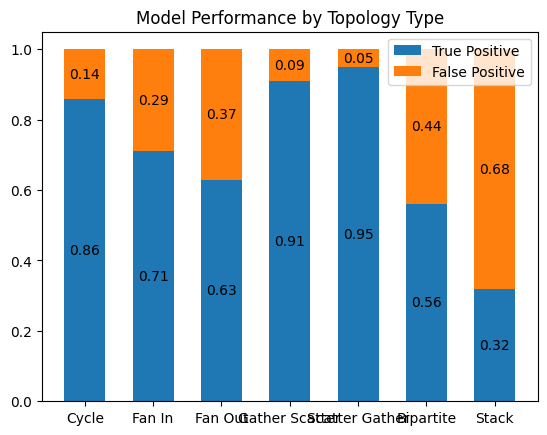

[array([0.86, 0.71, 0.63, 0.91, 0.95, 0.56, 0.32]),
 array([0.14, 0.29, 0.37, 0.09, 0.05, 0.44, 0.68])]

In [38]:
model.check_topology_performance(folder=ds1.folder, data=ds1.data)